In [1]:
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

C:\Users\91810\Anaconda3\lib\site-packages\torchvision\io\image.py:11: UserWarning: Failed to load image Python extension: [WinError 126] The specified module could not be found
  warn(f"Failed to load image Python extension: {e}")


In [2]:
class ResidualBlock(nn.Module):
    def __init__ (self, input_channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(input_channels, input_channels, kernel_size=3, padding=1, padding_mode='reflect')
        self.conv2 = nn.Conv2d(input_channels, input_channels, kernel_size=3, padding=1, padding_mode='reflect')
        self.instancenorm = nn.InstanceNorm2d(input_channels)
        self.activation = nn.ReLU()

    def forward(self, x):
        original_x = x.clone()
        x = self.conv1(x)
        x = self.instancenorm(x)
        x = self.activation(x)
        x = self.conv2(x)
        x = self.instancenorm(x)
        return original_x + x


class ContractingBlock(nn.Module):
    def __init__(self, input_channels, use_bn=True, kernel_size=3, activation='relu'):
        super(ContractingBlock, self).__init__()
        self.conv1 = nn.Conv2d(input_channels, input_channels * 2, kernel_size=kernel_size, padding=1, stride=2, padding_mode='reflect')
        self.activation = nn.ReLU() if activation == 'relu' else nn.LeakyReLU(0.2)
        if use_bn:
            self.instancenorm = nn.InstanceNorm2d(input_channels * 2)
        self.use_bn = use_bn


    def forward(self, x):
        x = self.conv1(x)
        if self.use_bn:
            x = self.instancenorm(x)
        x = self.activation(x)
        return x


class ExpandingBlock(nn.Module):
    def __init__(self, input_channels, use_bn=True):
        super(ExpandingBlock, self).__init__()
        self.conv1 = nn.ConvTranspose2d(input_channels, input_channels // 2, kernel_size=3, stride=2, padding=1, output_padding=1)
        if use_bn:
            self.instancenorm = nn.InstanceNorm2d(input_channels // 2)
        self.use_bn = use_bn
        self.activation = nn.ReLU()

    def forward(self, x):
        x = self.conv1(x)
        if self.use_bn:
            x = self.instancenorm(x)
        x = self.activation(x)
        return x
        
        
class FeatureMapBlock(nn.Module):
    def __init__(self, input_channels, output_channels):
        super(FeatureMapBlock, self).__init__()
        self.conv = nn.Conv2d(input_channels, output_channels, kernel_size=7, padding=3, padding_mode='reflect')
    def forward(self, x):
        x = self.conv(x)
        return x

In [3]:
class Generator(nn.Module):
    def __init__(self, input_channels, output_channels, hidden_channels = 64, a2n = False):
        super(Generator, self).__init__()
        self.a2n = a2n
        self.upfeature = FeatureMapBlock(input_channels, hidden_channels)  
        self.contract1 = ContractingBlock(hidden_channels)  
        self.contract2 = ContractingBlock(hidden_channels*2)
        mult = 4
        self.res0 = ResidualBlock(hidden_channels*mult)
        self.res1 = ResidualBlock(hidden_channels*mult)
        self.res2 = ResidualBlock(hidden_channels*mult)
        self.res3 = ResidualBlock(hidden_channels*mult)
        self.res4 = ResidualBlock(hidden_channels*mult)
        self.res5 = ResidualBlock(hidden_channels*mult)
        self.res6 = ResidualBlock(hidden_channels*mult)
        self.res7 = ResidualBlock(hidden_channels*mult)
        self.res8 = ResidualBlock(hidden_channels*mult)
        self.expand2 = ExpandingBlock(hidden_channels * 4)
        self.expand3 = ExpandingBlock(hidden_channels * 2)
        self.downfeature = FeatureMapBlock(hidden_channels, output_channels)
        self.tanh = torch.nn.Tanh()

    def forward(self, x):
        x0 = self.upfeature(x)
        x1 = self.contract1(x0)
        x2 = self.contract2(x1)
        x3 = self.res0(x2)
        x4 = self.res1(x3)
        x5 = self.res2(x4)
        x6 = self.res3(x5)
        x7 = self.res4(x6)
        x8 = self.res5(x7)
        x9 = self.res6(x8)
        x10 = self.res7(x9)
        x11 = self.res8(x10)
        x12 = self.expand2(x11)
        x13 = self.expand3(x12)
        if self.a2n:
            xn = self.downfeature(x13) + x # global shortcut for a2n gen
        else:
            xn = self.downfeature(x13)
        return self.tanh(xn)

In [4]:
class Discriminator(nn.Module):
    def __init__(self, input_channels, hidden_channels=64):
        super(Discriminator, self).__init__()
        self.upfeature = FeatureMapBlock(input_channels, hidden_channels)
        self.contract1 = ContractingBlock(hidden_channels, use_bn=False, kernel_size=4, activation='lrelu')
        self.contract2 = ContractingBlock(hidden_channels * 2, kernel_size=4, activation='lrelu')
        self.contract3 = ContractingBlock(hidden_channels * 4, kernel_size=4, activation='lrelu')
        self.final = nn.Conv2d(hidden_channels * 8, 1, kernel_size=1)

    def forward(self, x):
        x0 = self.upfeature(x)
        x1 = self.contract1(x0)
        x2 = self.contract2(x1)
        x3 = self.contract3(x2)
        xn = self.final(x3)
        return xn

In [5]:
import torch.nn.functional as F

adv_criterion = nn.MSELoss() 
recon_criterion = nn.L1Loss() 

n_epochs = 20
dim_A = 1
dim_B = 1
display_step = 200
batch_size = 1
lr = 0.0002
load_shape = 240
target_shape = 240
device = 'cpu'

In [6]:
gen_AB = Generator(dim_A, dim_B).to(device)
gen_BA = Generator(dim_B, dim_A).to(device)
gen_opt = torch.optim.Adam(list(gen_AB.parameters()) + list(gen_BA.parameters()), lr=lr, betas=(0.5, 0.999))
disc_A = Discriminator(dim_A).to(device)
disc_A_opt = torch.optim.Adam(disc_A.parameters(), lr=lr, betas=(0.5, 0.999))
disc_B = Discriminator(dim_B).to(device)
disc_B_opt = torch.optim.Adam(disc_B.parameters(), lr=lr, betas=(0.5, 0.999))

In [7]:
gen_AB_gs = Generator(dim_A, dim_B, a2n=True).to(device)
gen_BA_gs= Generator(dim_B, dim_A).to(device)
gen_opt_gs = torch.optim.Adam(list(gen_AB_gs.parameters()) + list(gen_BA_gs.parameters()), lr=lr, betas=(0.5, 0.999))
disc_A_gs = Discriminator(dim_A).to(device)
disc_A_opt_gs = torch.optim.Adam(disc_A_gs.parameters(), lr=lr, betas=(0.5, 0.999))
disc_B_gs = Discriminator(dim_B).to(device)
disc_B_opt_gs = torch.optim.Adam(disc_B_gs.parameters(), lr=lr, betas=(0.5, 0.999))

In [11]:
gen_AB_gs_al = Generator(dim_A, dim_B, a2n=True).to(device)
gen_BA_gs_al= Generator(dim_B, dim_A).to(device)
gen_opt_gs_al = torch.optim.Adam(list(gen_AB_gs_al.parameters()) + list(gen_BA_gs_al.parameters()), lr=lr, betas=(0.5, 0.999))
disc_A_gs_al = Discriminator(dim_A).to(device)
disc_A_opt_gs_al = torch.optim.Adam(disc_A_gs_al.parameters(), lr=lr, betas=(0.5, 0.999))
disc_B_gs_al = Discriminator(dim_B).to(device)
disc_B_opt_gs_al = torch.optim.Adam(disc_B_gs_al.parameters(), lr=lr, betas=(0.5, 0.999))

In [9]:
pre_dict = torch.load('../Saved Models/cycleGAN_20epochs_27800iters_1393images.pth')
gen_AB.load_state_dict(pre_dict['gen_AB'])
gen_BA.load_state_dict(pre_dict['gen_BA'])
gen_opt.load_state_dict(pre_dict['gen_opt'])
disc_A.load_state_dict(pre_dict['disc_A'])
disc_A_opt.load_state_dict(pre_dict['disc_A_opt'])
disc_B.load_state_dict(pre_dict['disc_B'])
disc_B_opt.load_state_dict(pre_dict['disc_B_opt'])

In [10]:
pre_dict_gs = torch.load('../Saved Models/cycleGAN_global_shortcut_20epochs_27800iters_1393images.pth')
gen_AB_gs.load_state_dict(pre_dict_gs['gen_AB'])
gen_BA_gs.load_state_dict(pre_dict_gs['gen_BA'])
gen_opt_gs.load_state_dict(pre_dict_gs['gen_opt'])
disc_A_gs.load_state_dict(pre_dict_gs['disc_A'])
disc_A_opt_gs.load_state_dict(pre_dict_gs['disc_A_opt'])
disc_B_gs.load_state_dict(pre_dict_gs['disc_B'])
disc_B_opt_gs.load_state_dict(pre_dict_gs['disc_B_opt'])

In [12]:
pre_dict_gs_al = torch.load('../Saved Models/cycleGAN_globalshortcut_anomaly_loss(0.1)_20_epochs.pth')
gen_AB_gs_al.load_state_dict(pre_dict_gs_al['gen_AB'])
gen_BA_gs_al.load_state_dict(pre_dict_gs_al['gen_BA'])
gen_opt_gs_al.load_state_dict(pre_dict_gs_al['gen_opt'])
disc_A_gs_al.load_state_dict(pre_dict_gs_al['disc_A'])
disc_A_opt_gs_al.load_state_dict(pre_dict_gs_al['disc_A_opt'])
disc_B_gs_al.load_state_dict(pre_dict_gs_al['disc_B'])
disc_B_opt_gs_al.load_state_dict(pre_dict_gs_al['disc_B_opt'])

In [13]:
from medpy.io import load
import matplotlib.pyplot as plt
import random
from sklearn.preprocessing import MinMaxScaler
import glob
import numpy as np
scaler = MinMaxScaler()

In [14]:
flair_list = sorted(glob.glob('../dataset/brats2015/BRATS2015_Testing/Testing/HGG_LGG/*/*Flair*/*.mha'))

In [106]:
# (68,90) ,(3,90)
i=54
n_slice=90
flair, _ = load(flair_list[i])
flair = scaler.fit_transform(flair.reshape(-1, flair.shape[-1])).reshape(flair.shape)
flair_slice = flair[:,:,n_slice]
flair = np.array(flair_slice)

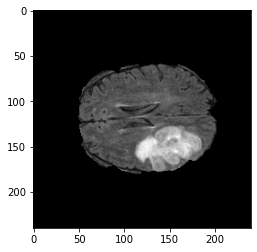

In [107]:
plt.imshow(flair_slice, cmap="gray")

In [108]:
flair_slice = torch.from_numpy(flair_slice)
flair_slice = flair_slice.repeat(1,1,1,1)
flair_slice = (flair_slice - 0.5)*2

In [109]:
flair_slice = flair_slice.to(device, dtype=torch.float)

In [110]:
translated_flair_slice = gen_AB(flair_slice)


In [111]:
translated_flair_slice_shifted = (translated_flair_slice+1)/2
image = translated_flair_slice_shifted.detach().cpu()
# plt.imshow(flair_slice, cmap="gray")
# plt.imshow(image.squeeze(), cmap='gray')

In [112]:
translated_flair_slice_gs = gen_AB_gs(flair_slice)

In [113]:
translated_flair_slice_shifted_gs = (translated_flair_slice_gs+1)/2
image_gs = translated_flair_slice_shifted_gs.detach().cpu()
# plt.imshow(flair_slice, cmap="gray")
# plt.imshow(image_gs.squeeze(), cmap='gray')

In [114]:
translated_flair_slice_gs_al = gen_AB_gs_al(flair_slice)

In [115]:
translated_flair_slice_shifted_gs_al = (translated_flair_slice_gs_al+1)/2
image_gs_al = translated_flair_slice_shifted_gs_al.detach().cpu()
# plt.imshow(flair_slice, cmap="gray")
# plt.imshow(image_gs_al.squeeze(), cmap='gray')

Text(0.5, 1.0, 'cyclegan + global shortcut + anomaly loss at 0.1')

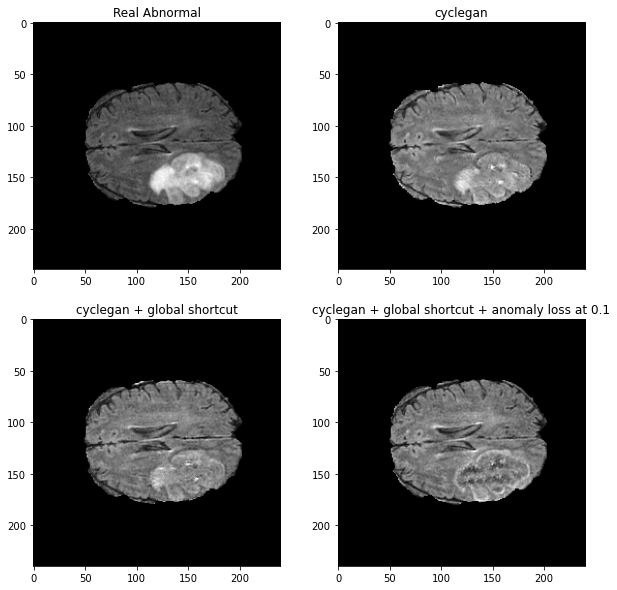

In [116]:
plt.figure(figsize = (10,10))
plt.subplot(221)
plt.imshow(flair.squeeze(), cmap='gray')
plt.title('Real Abnormal')

plt.subplot(222)
plt.imshow(image.squeeze(), cmap = 'gray')
plt.title('cyclegan')

plt.subplot(223)
plt.imshow(image_gs.squeeze(), cmap = 'gray')
plt.title('cyclegan + global shortcut')

plt.subplot(224)
plt.imshow(image_gs_al.squeeze(), cmap='gray')
plt.title('cyclegan + global shortcut + anomaly loss at 0.1')

In [63]:
cycled_flair_slice = gen_BA_gs(translated_flair_slice_gs)

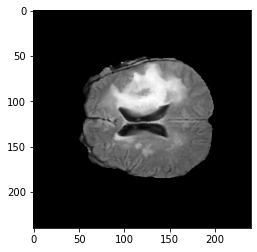

In [196]:
cycled_flair_slice_shifted = (cycled_flair_slice+1)/2
image = cycled_flair_slice_shifted.detach().cpu()
# plt.imshow(flair_slice, cmap="gray")
plt.imshow(image.squeeze(), cmap='gray')